<a id="title"></a>
# Flux Unit Conversions with synphot and stsynphot
***
## Learning Goals
By the end of this tutorial, you will:

- Perform conversions between various systems of flux and magnitude using the `synphot` and `stsynphot` packages.
- Extrapolate an output flux at a different wavelength than the input flux, by using a spectrum defined using the same packages.
- Provide a framework to adapt a more personalized and streamlined conversion process, if desired.

## Table of Contents
[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Input and output setup](#input) <br>
- [2.1 Units](#unit) <br>
- [2.2 Bandpasses](#band) <br>
- [2.3 Choosing a spectrum](#spec) <br>
- [2.4 User settings](#user) <br>

[3. Set up the conversion](#setting) <br>
[4. Perform the conversion and create a plot](#perform) <br>
[5. Examples](#ex) <br>
- [5.1 Flux in Jy to AB mag with a flat spectrum in $F_\nu$](#ex1) <br>
- [5.2 Flux in flam to Flux in flam along a blackbody](#ex2) <br>
- [5.3 Flux in fnu to flux in photnu, any spectrum (same wavelength)](#ex3) <br>
- [5.4 mag to mag from an HST bandpass to a Johnson bandpass, flat spectrum in $F_\lambda$](#ex4) <br>

[6. Conclusions](#conclusion) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction
This notebook is based on the prior "HST Photometric Conversion Tool" that returns unit conversions between various flux units and magnitude systems. It is not intended to replace more detailed functionality such as that provided by the [Exposure Time Calculator](https://etc.stsci.edu/) (ETC). Rather, it is intended to provide a simple, quick result for flux unit conversions.

`stsynphot` requires access to data distributed by the [Calibration Data Reference System](https://hst-crds.stsci.edu/) (CRDS) in order to operate. Both packages look for an environment variable called `PYSYN_CDBS` to find the directory containing these data.

Users can obtain these data files from the CDRS. Information on how to obtain the most up-to-date reference files (and what they contain) can be found [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/synphot-throughput-tables). An example of how to download these files using `curl` and set up this environment variable is presented in the imports section below.

For detailed instructions on how to install and set up these packages, see the [synphot](https://synphot.readthedocs.io/en/latest/#installation-and-setup) and [stsynphot](https://stsynphot.readthedocs.io/en/latest/#installation-and-setup) documentation.

<a id="imports"></a>
## 1. Imports

This notebook assumes you have created the virtual environment in [WFC3 notebooks’](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/README.md) installation instructions.

We import:
- *os* for setting environment variables
- *tarfile* for extracting a .tar archive

- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data

- *synphot* and *stsynphot* for evaluating synthetic photometry
- *astropy.units* and *synphot.units* for handling units

Additionally, we will need to set the `PYSYN_CDBS` environment variable *before* importing stsynphot. We will also create a Vega spectrum using synphot's inbuilt `from_vega()` method, as the latter package will supercede this method's functionality and require a downloaded copy of the latest Vega spectrum to be provided.

In [1]:
import os
import tarfile

import numpy as np
import matplotlib.pyplot as plt

from synphot import SourceSpectrum
from synphot.models import BlackBody1D, PowerLawFlux1D
from synphot.units import convert_flux

from astropy import units as u
from synphot import units as su

%matplotlib inline
vegaspec = SourceSpectrum.from_vega() 

This section obtains the WFC3 throughput component tables for use with `stsynphot`. This step only needs to be done once. If these reference files have already been downloaded, this section can be skipped.

In [2]:
cmd_input = 'curl -O https://archive.stsci.edu/hlsps/reference-atlases/hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar'
os.system(cmd_input)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  8  796M    8 66.4M    0     0  67.5M      0  0:00:11 --:--:--  0:00:11 67.5M

 24  796M   24  196M    0     0  99.3M      0  0:00:08  0:00:01  0:00:07 99.3M

 36  796M   36  294M    0     0  98.6M      0  0:00:08  0:00:02  0:00:06 98.6M

 52  796M   52  420M    0     0   105M      0  0:00:07  0:00:03  0:00:04  105M

 69  796M   69  552M    0     0   110M      0  0:00:07  0:00:04  0:00:03  110M

 85  796M   85  683M    0     0   114M      0  0:00:06  0:00:05  0:00:01  123M

100  796M  100  796M    0     0   116M      0  0:00:06  0:00:06 --:--:--  123M


0

Once the downloaded is complete, extract the file and set the environment variable `PYSYN_CDBS` to the path of the `trds` subdirectory.  The next cell will do this for you, as long as the `.tar` file downloaded above has not been moved.

In [3]:
tar_archive = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar'
extract_to = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed'
with tarfile.open(tar_archive, 'r') as tar:
    tar.extractall(path=extract_to)

os.environ['PYSYN_CDBS'] = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed/grp/redcat/trds/'

Now, after having set up `PYSYN_CDBS`, we import stsynphot. A warning regarding the Vega spectrum is expected here.

In [4]:
import stsynphot as stsyn

<a id="input"></a>
## 2. Input and output setup

<a id="unit"></a>
### 2.1 Units

The conversion framework below will accept any `astropy` or `synphot` unit with dimensions of spectral flux density ($F_\lambda$ or $F_\nu$) or photon flux density. Flux units with any of the following dimensions will be supported by the tool:
- [power] [area] [wavelength]$^{-1}$
- [power] [area] [frequency]$^{-1}$
- photons [area] [wavelength]$^{-1}$
- photons [area] [frequency]$^{-1}$

Alternatively, a magnitude system may be specified as the unit for the input or the output in the same way that a flux density would be. The tables below lists flux units which are defined by name in `astropy` and `synphot`, and the magnitude systems supported by the tool.

| Unit | Definition | astropy/synphot attribute |
|:---|:---:|:---
| Jansky | $$10^{-26} \text{ W} \text{ m}^{-2} \text{ Hz}^{-1}$$ | `astropy.units.Jy` |
| fnu | $$\text{erg} \text{ s}^{-1} \text{ cm}^{-2} \text{ Hz}^{-1}$$ | `synphot.units.FNU` |
| flam | $$\text{erg} \text{ s}^{-1} \text{ cm}^{-2} \text{ Å}^{-1}$$ |`synphot.units.FLAM` |
| photnu | $$\text{photons} \text{ s}^{-1} \text{ cm}^{-2} \text{ Hz}^{-1}$$ | `synphot.units.PHOTNU` |
| photlam | $$\text{photons} \text{ s}^{-1} \text{ cm}^{-2} \text{ Å}^{-1}$$ | `synphot.units.PHOTLAM` |

| Mag System | astropy/synphot attribute |
|:---|:---|
| ABmag | `astropy.units.ABmag` |
| STmag | `astropy.units.STmag` |
| vegamag | `synphot.units.VEGAMAG` |

For more information on accepted units in `synphot`, refer to the documentation [here](https://synphot.readthedocs.io/en/latest/synphot/units.html). 

<a id="band"></a>
### 2.2 Bandpasses

When selecting a magnitude as an input or output, the tool will need a bandpass to be defined, which is done with a string of [observation mode](https://stsynphot.readthedocs.io/en/latest/stsynphot/obsmode.html#), or obsmode, keywords. The pivot wavelength for that bandpass will then serve as the characteristic wavelength to be used for the conversion.

For HST bandpasses, `stsynphot` accounts for the telescope's optics by combining throughput information along the entire optical path. As an example, `'wfc3, uvis2, f475w, mjd#59367'` tells `stsynphot` to retrieve the latest throughput tables for the UVIS2 detector on WFC3, through the F475W filter for the Modified Julian Date 59367 (June 1, 2021). The option to specify a Julian date is provided for instruments which show changes in sensitivity over time. If no date is specified, `stsynphot` will use the reference epoch for each instrument as default.

As the required and optional obsmode keywords vary from instrument to instrument, it would be impractical to list the available options here in their entirety. Please refer to the [full list](https://stsynphot.readthedocs.io/en/latest/stsynphot/appendixb.html#stsynphot-appendixb) of available obsmode keywords for details on how to specify HST bandpasses.

For non-HST filter systems, the only required keywords are the filter system's name and that of the desired filter within that system (e.g. `'johnson, v'`). A list of the non-HST filter systems accepted by `stsynphot` is given here:

| System    | Bands               |
|:----------|:--------------------|
| cousins   | r, i                |
| galex     | nuv, fuv            |
| johnson   | u, b, v, r, i, j, k |
| landolt   | u, b, v, r, i       |
| sdss      | u, g, r, i, z,      |
| stromgren | u, v, b, y          |

<a id="spec"></a>
### 2.3 Choosing a spectrum

You'll also need to define a spectrum, which the tool will use to extrapolate your input flux to an output at a different wavelength.

The embedded code below shows how to generate or load various useful spectra. You can simply copy one of them into the cell below and modify as appropriate, or create your own. For more information, see the [Source Spectrum documentation](https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#).

Some notes:
- For evaluation and plotting, these models default to outputting flux in photlam, however, the output unit may be specified with the `flux_unit` keyword argument.

- `synphot.models.BlackBody1D` outputs a function according to Planck's law, which means that the output unit carries an implicit "per unit solid angle," in steradians. For a normalized blackbody, you can use `BlackBodyNorm1D`, whose output is normalized to a 1 solar radius star at a distance of 1 kpc, or multiply your source spectrum by some solid angle of your choosing.

- `synphot.models.PowerLawFlux1D` uses the definition $f(x) = A (\frac{x}{x_0})^{-\alpha}$, where $A$ is input flux (`flux_in`), and $x_0$ is the input wavelength (`wavelength_in`). Note the negative sign in front of the power law index $\alpha$. The model can generate curves with $x$ as either frequency or wavelength, but the example here assumes that wavelength will be used. The y-axis unit will be taken from $A$. 

- A wide array of reference spectra are available for download from spectral atlases located [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs).



Example spectrum definitions:

```python
# Blackbody
bb_temp = 5800 * u.K

model = BlackBody1D(bb_temp)
spectrum = SourceSpectrum(model)

# Power law 
pl_index = 0

model = PowerLawFlux1D(amplitude=flux_in, x_0=wavelength_in, alpha=pl_index)
spectrum = SourceSpectrum(model)
                                             
# Load from a FITS table
spectrum = SourceSpectrum.from_file('/path/to/your/spectrum.fits')
```

The notebook has been set up to perform an extrapolation from $V = 0.0$ in the Vega system to the R-band in the same system, using the Vega spectrum defined in the imports cell. Further examples of input and output settings are available at the bottom of this notebook.

<a id="user"></a>
### 2.4 User settings

First, we define our conversion input settings:
- `value_in`: numerical value of input flux/mag (float)
- `unit_in`: unit or mag system for input value
- `waveband_in`: input's wavelength (float) for flux, or bandpass obsmode (string) for magnitudes. The use of "waveband" here is only for the purpose of variable naming, since this can be either a wavelength or a bandpass.
- `wavelength_unit`: wavelength unit (used for plots, so needs to be specified even when using a bandpass)

In [5]:
value_in = 0.0
unit_in = su.VEGAMAG
waveband_in = 'johnson, v'
wavelength_unit = u.nm 

Next, we define our conversion output settings:
- `unit_out`: unit or mag system for the output
- `waveband_out`: wavelength (float) or bandpass obsmode (string) to find output for; if a wavelength, the unit specified in the cell above by `wavelength_unit` will be used.

In [6]:
unit_out = su.VEGAMAG
waveband_out = 'cousins, r'

Finally, we define our spectrum to use (copy/paste from above, or define your own).

In [7]:
spectrum = vegaspec

<a id="setting"></a>
## 3. Set up the conversion

Now, we need to run a few cells that will set up the conversion. First, we check whether the input and output are a flux or a magnitude, and set some variables appropriately. Then, we scale the chosen spectrum such that it passes through the defined input so the extrapolation to the output wavelength will give an accurate result.

Note that the default plotting unit is set to the input unit for conversions made from flux units, and photlam for conversions from magnitudes. This may be altered, if desired, by changing the `plot_unit` variable definitions in the cell below.

**Note: No inputs required for the cells below. All the inputs were assigned in [Section 2.4](#user).**

First, let's combine input value and unit as a quantity, then list the systems that will work for the tool.

In [8]:
quantity_in = value_in * unit_in
mag_systems = [u.STmag, u.ABmag, su.VEGAMAG]
flux_systems = ['spectral flux density', 'spectral flux density wav', 
                'photon flux density', 'photon flux density wav']

Next, let's get inputs set up for following steps. Here are the three possible outcomes:
- **If the input is a magnitude,**
    - define bandpass with input obsmode string
    - pivot wavelength of input bandpass
    - set `flux_in` to equivalent flux in photlam at pivot wavelength (Vega spectrum needed if using VEGAMAG)
    - set plotting unit and flux for later
    
    
- **If the input is a flux,**
    - combine wavelength for flux and unit as the input wavelength
    - set plotting unit and flux for later


- **If anything else, print**
    - `unit_in not a flux density unit or magnitude system`

In [9]:
if unit_in in mag_systems:
    mag_in = quantity_in
    bandpass_in = stsyn.band(waveband_in)
    wavelength_in = bandpass_in.pivot().to(wavelength_unit)
    flux_in = convert_flux(wavelength_in, quantity_in, su.PHOTLAM,
                           vegaspec=vegaspec)
    plot_unit = su.PHOTLAM
    plot_flux_in = convert_flux(wavelength_in, flux_in, plot_unit)
elif unit_in.physical_type in flux_systems:
    flux_in = quantity_in
    wavelength_in = waveband_in * wavelength_unit 
    plot_unit = unit_in
    plot_flux_in = convert_flux(wavelength_in, flux_in, plot_unit)
else:
    print('unit_in not a flux density unit or magnitude system')

We perform a similar setup for outputs:
- **If the output is a magnitude,**
    - use output wavelength to calculate output bandpass
    - output bandpass's pivot wavelength
    
    
- **If the output is a flux,**
    - combine wavelength for flux and unit as output wavelength
    

- **If anything else, print**
    - `unit_out not a flux density unit or magnitude system`

In [10]:
if unit_out in mag_systems:
    bandpass_out = stsyn.band(waveband_out)
    wavelength_out = bandpass_out.pivot().to(wavelength_unit)
elif unit_out.physical_type in flux_systems:
    wavelength_out = waveband_out * wavelength_unit
else:
    print('unit_out not a flux density unit or magnitude system')    

Finally, we convert the flux, scale, and multiply by our spectrum. The default evaluation unit is set to photlam.

In [11]:
scale = convert_flux(wavelength_in, flux_in, su.PHOTLAM) / spectrum(wavelength_in)
scaled_spectrum = spectrum * scale

<a id="perform"></a>
## 4. Perform the conversion and create a plot

We can now find our output by using the `convert_flux` function from `synphot`. We will first scale the spectrum defined above such that its value at the input wavelength is that of the input flux. Then, we convert the scaled spectrum's value at the *output* wavelength to the selected output units, as well as the unit that will be used for plotting. 

In [12]:
if unit_out in mag_systems:
    flux_out = convert_flux(wavelength_out, scaled_spectrum(wavelength_out), unit_out,
                            vegaspec=vegaspec)
    plot_flux_out = convert_flux(wavelength_out, scaled_spectrum(wavelength_out), plot_unit)
else:
    flux_out = convert_flux(wavelength_out, scaled_spectrum(wavelength_out), unit_out)
    plot_flux_out = convert_flux(wavelength_out, scaled_spectrum(wavelength_out), plot_unit)
    
value_out = flux_out.value

Print the input and output values.

In [13]:
print(f'Input: {value_in:.4f} {unit_in:s} at {wavelength_in.value:.1f} {wavelength_in.unit:s}\n')
print(f'Input: {value_out:.4f} {unit_out:s} at {wavelength_out.value:.1f} {wavelength_out.unit:s}\n')
# print(f'Output: {float(value_out):.4} {} at {:.1f} {}'.format(, str(unit_out), wavelength_out.value, str(wavelength_out.unit)))

Input: 0.0000 VEGAMAG at 547.9 nm

Input: -0.0000 VEGAMAG at 647.3 nm



While not strictly necessary for performing the conversion, plotting the selected spectrum with the input and output points can be a useful check to see if the spectrum looks like what you're expecting.

Let's define a set of wavelengths and minimum/maximum bounds for the plot.

In [14]:
wavelength_settings = [wl.value for wl in [wavelength_in, wavelength_out]]
short = min(wavelength_settings)
long = max(wavelength_settings)

if short == long:  # In case wavelength_in == wavelength_out
    diff = 10.
else:
    diff = long - short
right = long + diff
left = max([short - diff, 0.1])
wavelength_space = np.linspace(left, right, 10000) * wavelength_unit

We will also set the colors for the in/out markers.

In [15]:
if wavelength_in.value > wavelength_out.value:
    c_in = 'r'
    c_out = 'b'
else: 
    c_in = 'b'
    c_out = 'r'

Plot the spectrum, input, and output. If the input was a magnitude, then `plot_unit` ([see Section 3](#setting)) will be used. In addition, if the input and output wavelength are the same, then print the input and output.

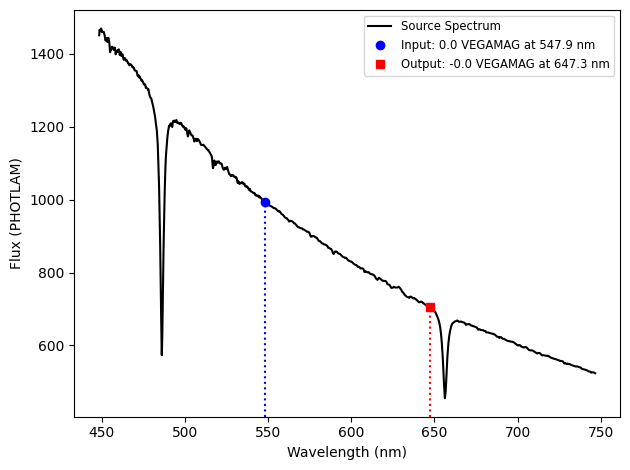

In [16]:
plt.figure()

# Plot spectrum
plt.plot(wavelength_space, scaled_spectrum(wavelength_space, flux_unit=plot_unit), c='k', label='Source Spectrum')

# Plot input
plt.plot(wavelength_in.value, plot_flux_in.value,
         marker='o', color=c_in, ls='none', 
         label='Input: {:.4} {} at {:.1f} {}'.format(
              float(value_in), str(unit_in), wavelength_in.value, str(wavelength_in.unit)))

# Plot output
plt.plot(wavelength_out.value, plot_flux_out.value,
         marker='s', color=c_out, ls='none', 
         label='Output: {:.4} {} at {:.1f} {}'.format(
              float(value_out), str(unit_out), wavelength_out.value, str(wavelength_out.unit)))

# Set heights for dotted lines to markers as % of plot range
bottom, top = plt.ylim()
yrange = top - bottom
inheight = (plot_flux_in.value - bottom) / yrange
outheight = (plot_flux_out.value - bottom) / yrange

# Plot dotted lines to markers
plt.axvline(wavelength_in.to(wavelength_unit).value, ymax=inheight, ls=':', c=c_in)
plt.axvline(wavelength_out.to(wavelength_unit).value, ymax=outheight, ls=':', c=c_out)

# Miscellaneous
plt.ylabel('Flux ({})'.format(str(plot_unit)))
plt.xlabel('Wavelength ({})'.format(str(wavelength_unit)))
plt.legend(fontsize='small')    
plt.tight_layout()

<a id="ex"></a>
## 5. Examples

Here, we provide some examples to illustrate a few of the many conversions which are possible. If desired, you may run an example cell to set the inputs for the tool, then run through the notebook (without running the cells in [Section 2.4](#user)) to see the results. Each cell will define an input, output, and spectrum.

<a id="ex1"></a>
### 5.1. Flux in Jy to AB mag with a flat spectrum in $F_\nu$
Run cell then go to [Section 3](#setting) to convert flux and plot.

In [17]:
# Input: 3631 Jy at 550. nm
value_in = 3631.      
unit_in = u.Jy
waveband_in = 550.
wavelength_unit = u.nm

# Output: Johnson V mag (AB)
unit_out = u.ABmag
waveband_out = 'Johnson, V'
    
# Spectrum: Flat power law in F_nu
pl_index = 0
model = PowerLawFlux1D(amplitude=flux_in, x_0=wavelength_in, alpha=pl_index)
spectrum = SourceSpectrum(model)

<a id="ex2"></a>
### 5.2. Flux in flam to Flux in flam along a blackbody
Run cell then go to [Section 3](#setting) to convert flux and plot.

In [18]:
# Input: 1.234e-8 flam at 500. nm
value_in = 1.234e-8    
unit_in = su.FLAM
waveband_in = 500.
wavelength_unit = u.nm

# Output: flam at 800. nm
unit_out = su.FLAM
waveband_out = 800.
    
# Spectrum: 5800 K blackbody
bb_temp = 5800 * u.K
model = BlackBody1D(bb_temp)
spec = SourceSpectrum(model)

<a id="ex3"></a>
### 5.3. Flux in fnu to flux in photnu, any spectrum (same wavelength)
Run cell then go to [Section 3](#setting) to convert flux and plot. Note the spectrum is irrelevant since conversion is at the same wavelength.

In [19]:
# Input: 1.234e-21 fnu at 686. nm
value_in = 1.234e-21    
unit_in = su.FNU
waveband_in = 686.
wavelength_unit = u.nm

# Output: photnu at 686. nm
unit_out = su.PHOTNU
waveband_out = 686.
    
# Spectrum: 5800 K blackbody
bb_temp = 5800 * u.K
model = BlackBody1D(bb_temp)
spectrum = SourceSpectrum(model)

<a id="ex4"></a>
### 5.4. mag to mag from an HST bandpass to a Johnson bandpass, flat spectrum in $F_\lambda$
Run cell then go to [Section 3](#setting) to convert flux and plot. Note we run `convert_flux` for the power law amplitude to ensure the spectrum is flat in $F_\lambda$ rather than in photlam.

In [20]:
# Input: STmag = 12.240, F606W filter on WFC3 UVIS 2
value_in = 12.240      
unit_in = u.STmag
waveband_in = 'wfc3, uvis2, f606w, mjd#59367'
wavelength_unit = u.nm

# Output: Johnson V mag (AB)
unit_out = u.STmag
waveband_out = 'Johnson, V'
    
# Spectrum: Flat power law in F_lambda
pl_index = 0
model = PowerLawFlux1D(amplitude=convert_flux(606 * u.nm, 1., su.FLAM), x_0=606 * u.nm, alpha=pl_index)
spec = SourceSpectrum(model)
model = PowerLawFlux1D(amplitude=flux_in, x_0=wavelength_in, alpha=pl_index)

<a id="conclusion"></a>
## 6. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Performing conversions between various systems of flux and magnitude using the `synphot` and `stsynphot` packages.
- Extrapolating an output flux at a different wavelength than the input flux.
- Adapting a more personalized and streamlined conversion process.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see sections 9.5.2 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Aidan Pidgeon, Joel Green; WFC3 Instrument Team

**Updated on:** 2021-09-13

<a id="cite"></a>
## Citations

If you use `numpy`, `astropy`, `synphot`, or `stsynphot` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `synphot`](https://synphot.readthedocs.io/en/latest/)
* [Citing `stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html)

***
[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 